# Installation
Install from GitHub as described in [the docs](http://qcodes.github.io/Qcodes/start/index.html).

In [2]:
import numpy as np
import qcodes as qc

# Instrument setup

At this point, each measurement setup needs to define which instruments they use. See [the docs](http://qcodes.github.io/Qcodes/user/intro.html#instrument). For demonstration purposes, here I just use dummy instruments `dac` and `dmm`.

In [3]:
from qcodes.tests.instrument_mocks import DummyInstrument
dac = DummyInstrument(name="dac", gates=['ch1', 'ch2'])
dmm = DummyInstrument(name="dmm", gates=['idc', 'ig', 'ia', 'ib', 'ic', 'id', 'ie', 'ih', 'ii', 'ij', 'ik', 'il', 'im', 'io', 'ip'])

import random
dmm.idc.get = lambda: random.gauss(1, 0.1)
dmm.ig.get = lambda: random.gauss(0, 0.01)

You can set `step` and `inter_delay` on any parameters. These will apply to all future attempts to set the value, including those in loops. For instance, if `dac.ch1` can be ramped at a maximum speed of 0.1 V / ms, then do this:

In [4]:
dac.ch1.step = 0.1
dac.ch1.inter_delay = 0.001

# Experiment setup

The first time you run qcodes on a new computer, you need to create the SQLite database. See [the docs](https://qcodes.github.io/Qcodes/dataset/index.html) for details on the design of the dataset and database. You will then want to make a new experiment to hold your data. At the very least, make a new experiment when you change out your samples.

In [5]:
qc.initialise_database()
qc.new_experiment(name='demo', sample_name='my best sample')

demo#my best sample#45@/home/spxtr/experiments.db
-------------------------------------------------

# Measurement

In [20]:
import io
import time

import numpy as np
import qcodes as qc
from qcodes.dataset.measurements import Measurement
from qcodes.instrument_drivers.stanford_research.SR830 import SR830
import pyqtgraph as pg
import pyqtgraph.exporters
from IPython import display


pg.setConfigOption('background', 'w')
pg.setConfigOption('foreground', 'k')


def _sec_to_str(d):
    h, m, s = int(d/3600), int(d/60) % 60, int(d) % 60
    return f'{h}h {m}m {s}s'


# https://stackoverflow.com/questions/23151612/pyqtgraph-how-to-plot-time-series-date-and-time-on-the-x-axis
class TimeAxis(pg.AxisItem):
    def tickStrings(self, values, scale, spacing):
        strns = []
        for x in values:
            try:
                strns.append(time.strftime("%H:%M:%S", time.localtime(x)))
            except ValueError:  # Windows can't handle dates before 1970
                strns.append('')
        return strns


class _FeedbackLockin:
    def __init__(self, fbl, channels, gains, plots):
        self._fbl = fbl
        self._fbl_channels = channels
        self._fbl_gains = gains
        self._fbl_plots = plots
        
    def register(self, meas, setpoints):
        for c in self._fbl_channels:
            meas.register_custom_parameter(f'fbl_c{c}_x', label=f'FBL Channel {c} X', unit='V')
            meas.register_custom_parameter(f'fbl_c{c}_p', label=f'FBL Channel {c} Phase', unit='deg')
    
    def make_plot(self, win, xlabel, ylabel=None):
        return False
    
    def measure(self, setpoint):
        points = []
        d = self._fbl.get_v_in(self._fbl_channels)
        for i, (c, (x, theta)) in enumerate(zip(self._fbl_channels, d)):
            if self._fbl_gains is not None:
                x = x / self._fbl_gains[i]
            points.extend([(f'fbl_c{c}_x', x), (f'fbl_c{c}_p', theta)])
        return points
    
    
class _SR830:
    def __init__(self, l, gain, autorange, plot):
        self._l = l
        self._gain = gain
        self._plot = plot
        self._ar = autorange
    
    def register(self, meas, setpoints):
        meas.register_parameter(l.X, setpoints=setpoints)
        meas.register_parameter(l.Y, setpoints=setpoints)
    
    def make_plot(self, win, xlabel, ylabel=None):
        return False
    
    def measure(self, setpoint):
        if self._ar:
            self._autorange()
        x, y = self._l.snap('x', 'y')
        x, y = x / gain, y / gain
        return [(self._l.X, x), (self._l.Y, y)]
    
    def _autorange(self, max_changes=2):
        def autorange_once():
            r = self._l.R.get()
            sens = self._l.sensitivity.get()
            if r > 0.9 * sens:
                return self._l.increment_sensitivity()
            elif r < 0.1 * sens:
                return self._l.decrement_sensitivity()
            return False
        sets = 0
        while autorange_once() and sets < max_changes:
            sets += 1
            time.sleep(10*srs.time_constant.get())


class _Param:
    def __init__(self, p, gain, plot):
        self._p = p
        self._gain = gain
        self._plot = plot
    
    def register(self, meas, setpoints):
        meas.register_parameter(self._p, setpoints=setpoints)
    
    def make_plot(self, win, xlabel, ylabel):
        if not self._plot:
            return False
        if xlabel is None:
            # Time series
            self._spi = pg.ScatterPlotItem()
            ta = TimeAxis(orientation='bottom')
            ta.enableAutoSIPrefix(False)
            win.addPlot(title=self._p.name, labels={
                'left': f'{self._p.label} ({self._p.unit})',
                'bottom': 'Time'}, rowspan=2,
                axisItems={'bottom': ta}).addItem(self._spi)
        elif ylabel is None:
            # 1D sweep
            self._spi = pg.ScatterPlotItem()
            win.addPlot(title=self._p.name, labels={
                'left': f'{self._p.label} ({self._p.unit})',
                'bottom': xlabel}, rowspan=2).addItem(self._spi)
        else:
            # 2D sweep
            self._im = pg.ImageItem()
            win.addPlot(title=self._p.name, labels={
                'left': ylabel,
                'bottom': xlabel}, rowspan=2).addItem(self._im)
        return True
    
    def measure(self, x_setpoint, y_setpoint):
        v = self._p.get()
        v = v / self._gain
        if self._plot and y_setpoint is None:
            self._spi.addPoints(x=[x_setpoint], y=[v])
        elif self._plot:
            pass
        return [(self._p, v)]

    
def interruptible(func):
    def wrapper(*args, **kwargs):
        t0 = time.monotonic()
        try:
            return func(*args, **kwargs)
        except KeyboardInterrupt:
            print('Interrupted.')
        args[0].display_plot_and_close()
        print(f'Completed in {_sec_to_str(time.monotonic() - t0)}.')
    return wrapper
      
    
class Sweep:
    def __init__(self):
        self._measurables = []
        self._win = None
    
    def follow_param(self, p, gain=1.0, plot=True):
        self._measurables.append(_Param(p, gain, plot))

    def follow_sr830(self, l, gain=1.0, autorange=True, plot=True):
        self._measurables.append(_SR830(l, gain, autorange, plot))
        
    def follow_fbl(self, fbl, channels, gains=None, plots=None):
        self._measurables.append(_FeedbackLockin(fbl, channels, gains, plots))

    def _create_measurement(self, *set_params):
        meas = Measurement()
        for p in set_params:
            meas.register_parameter(p)
        meas.register_custom_parameter('time', label='Time', unit='s')
        for m in self._measurables:
            m.register(meas, (*set_params, 'time',))
        return meas
    
    def _create_plots(self, x_param=None, y_param=None):
        xlabel = None if x_param is None else f'{x_param.label} ({x_param.unit})'
        ylabel = None if y_param is None else f'{y_param.label} ({y_param.unit})'
        
        cols = 0
        self._win = pg.GraphicsLayoutWidget()
        for m in self._measurables:
            if m.make_plot(self._win, xlabel, ylabel):
                cols += 1
                if cols % 4 == 0:
                    self._win.nextRow()
                    self._win.nextRow()
        self._win.show()
    
    def display_plot_and_close(self):
        if self._win is None:
            return
        img = pg.QtGui.QImage(self._win.viewRect().size().toSize(), pg.QtGui.QImage.Format_RGB32)
        painter = pg.QtGui.QPainter(img)
        self._win.render(painter)
        b = pg.QtCore.QBuffer()
        img.save(b, 'png', 0)
        display.display(display.Image(data=b.data(), format='png'))
        del painter
        self._win.close()
        self._win = None
        
    @interruptible
    def watch(self, max_duration=60, inter_delay=0):
        t0 = time.monotonic()
        meas = self._create_measurement()
        with meas.run() as datasaver:
            self._create_plots()
            while time.monotonic() - t0 < max_duration:
                time.sleep(inter_delay)
                t = time.time()
                data = [('time', t)]
                for m in self._measurables:
                    data.extend(m.measure(t, None))
                datasaver.add_result(*data)
                pg.QtGui.QApplication.processEvents()
                
    @interruptible
    def sweep(self, set_param, vals, inter_delay=0):
        print(f'Minimum duration: {_sec_to_str(len(vals) * inter_delay)}')
        meas = self._create_measurement(set_param)
        with meas.run() as datasaver:
            self._create_plots(set_param)
            for setpoint in vals:
                set_param.set(setpoint)
                time.sleep(inter_delay)
                data = [(set_param, setpoint), ('time', time.time())]
                for m in self._measurables:
                    data.extend(m.measure(setpoint, None))
                datasaver.add_result(*data)
                pg.QtGui.QApplication.processEvents()
    
    @interruptible
    def megasweep(self, slow_p, slow_v, fast_p, fast_v, slow_delay=0, fast_delay=0):
        print(f'Minimum duration: {_sec_to_str(len(slow_v)*len(fast_v)*fast_delay + len(slow_v)*slow_delay)}')
        meas = self._create_measurement(slow_p, fast_p)
        with meas.run() as datasaver:
            self._create_plots(slow_p, fast_p)
            for ov in slow_v:
                slow_p.set(ov)
                time.sleep(slow_delay)
                for iv in fast_v:
                    fast_p.set(iv)
                    time.sleep(fast_delay)
                    data = [(slow_p, ov), (fast_p, iv), ('time', time.time())]
                    for m in self._measurables:
                        data.extend(m.measure(ov, iv))
                    datasaver.add_result(*data)
                    pg.QtGui.QApplication.processEvents()


def sweep1d(instr, start, end, step, delay, params):
    # Example: sweep1D(Vg, 0, 1, 0.1, 0.5, [srs1, srs2, [FBL, 0, 1, 2, 10, 11]])
    s = Sweep()
    for p in params:
        if isinstance(p, SR830):
            s.follow_sr830(p)
        elif p is list and p[0].name == ' FBL':
            # TODO: Need to do better in the future.
            channels = p[1:]
            s.follow_fbl(channels)
        else:
            s.follow_param(p)
    s.sweep(instr, np.arange(start, end, step), inter_delay=delay)

In [21]:
s = Sweep()
s.follow_param(dmm.ig, gain=10)
s.follow_param(dmm.idc)
s.follow_param(dmm.ia)
s.follow_param(dmm.ib)
s.follow_param(dmm.ic)
s.follow_param(dmm.id)
s.follow_param(dmm.ie)
s.follow_param(dmm.ih)
s.follow_param(dmm.ii)
s.follow_param(dmm.ij)
s.follow_param(dmm.ik)
s.follow_param(dmm.il)
s.follow_param(dmm.im)
s.follow_param(dmm.io)

#s.sweep(dac.ch1, np.linspace(0, 25, 10), inter_delay=1)
#s.watch(max_duration=10, inter_delay=0.5)
s.megasweep(dac.ch1, np.linspace(0, 25, 10), dac.ch2, np.linspace(0, 10, 10), slow_delay=1, fast_delay=0.1)

Minimum duration: 0h 0m 20s
Starting experimental run with id: 857


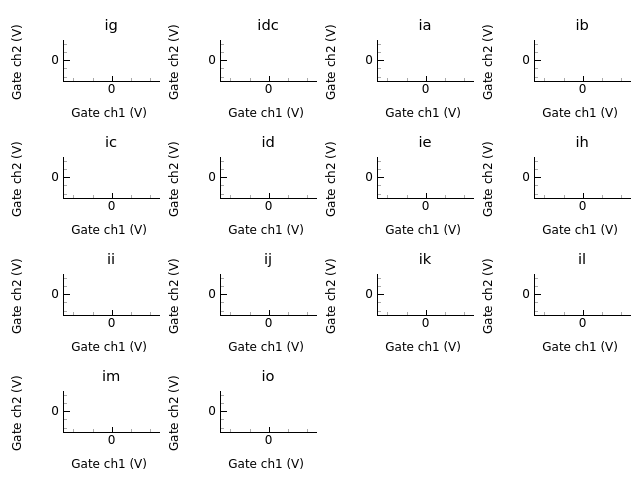

In [22]:
s.display_plot_and_close()

In [ ]:
s = Sweep()
s.follow_param(dmm.ig, gain=10)
s.follow_param(dmm.idc)

# Sweep from 0 to 25.
s.sweep(dac.ch1, np.linspace(0, 25, 10), inter_delay=0.5)
# Sweep from 0 to 25 then back to 0.
s.sweep(dac.ch1, np.concatenate((
    np.linspace(0, 25, 10),
    np.linspace(25, 0, 10))), inter_delay=0.1)
# Watch the parameters for up to 100 seconds.
s.watch(max_duration=100, inter_delay=0.5)
# Sweep along two axes, slow then fast.
s.megasweep(
    dac.ch1, np.linspace(0, 10, 10),
    dac.ch2, np.linspace(0, 10, 10), inter_delay=0.1)

## Where is the data?

See the `get_data_by_id` docstring.

TODO: Make this easier to save to a csv or something.

In [ ]:
get_data_by_id(datasaver.run_id)